In [1]:

# import pysparnn.cluster_index as ci
# import scipy.sparse
import os
import math
import numpy as np
import pandas as pd
import random
from utils import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff

!pip install surprise
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
data = pd.read_csv("ml-1m/ratings.txt",sep='::',index_col=False,names=["user_id","item_id","rating","timestamp"],header=None,engine='python')
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
# Iteratively filters out users and items with fewer than the threshold number of interactions until no changes happen.
data = threshold_interactions_df(data,'user_id','item_id',100,100)
matrix,rid_to_idx, idx_to_rid, cid_to_idx, idx_to_cid = df_to_matrix(data,"user_id","item_id","rating")

al,train,_ = train_test_split(matrix,1) # train_test_split(interactions, split_count, fraction=None)
# train: a matrix containing 40 held-out rating per user

# ml 1M
X_matrix,test,_ = train_test_split(al,30)

# train dimensions
print("train shape:", train.shape)
print("test shape:", test.shape)


Starting interactions info
Number of rows: 6040
Number of cols: 3706
Sparsity: 4.468%
Ending interactions info
Number of rows: 2828
Number of columns: 1919
Sparsity: 14.284%
train shape: (2828, 1919)
test shape: (2828, 1919)


In [5]:
def i_variance(matirx):
    c = matrix.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()

def i_random(matirx):
    c = matrix.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()

def i_entropy(matirx):
    entropy = []
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        len_rating = len(ratings)
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/len_rating)*math.log(count_r[c]/len_rating)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_entropy_0(matirx):
    entropy = []
    c_all = matirx.shape[0]
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        count_r[0] = c_all - matirx.getcol(item).count_nonzero()
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/c_all)*math.log(count_r[c]/c_all)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_pop(matrix):
    popularity = []
    for item in range(0, matrix.shape[1]):
        popularity.append(matrix.getcol(item).count_nonzero())
        
    return (np.asarray(popularity))

def log_pop_entropy(matrix):
    entropy = i_entropy(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def log_pop_entropy0(matrix):
    entropy = i_entropy_0(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def sqrt_pop_variance(matrix):
    variance = i_variance(matrix)
    popularity = i_pop(matrix)
    scores = np.sqrt(popularity) *  variance 
    return (np.asarray(scores))

def helf(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def helf0(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy_0(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def i_co_rate(matrix):
    matrix_c = matrix.copy()
    matrix_c[matrix_c != 0] = 1
    c= matrix_c.T.dot(matrix_c)
    c.setdiag(0, k=0)
    
    return np.asarray(c.sum(axis=0))[0]

In [ ]:
def elicitation_np(train,test,X,strategy,iteration,k,positive=False):
    # X: known by the users but not the system
    rmse,mae = [],[]
    
    # Performance before elicitation
    train_df = matrix_to_df_2(train,idx_to_rid,idx_to_cid)
    reader = Reader(rating_scale=(1, 5)) # Use Surprise’s Reader to format the data 
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    # Purpose: Load the training data into a Surprise Dataset object.

    data_rr = data_r.build_full_trainset()
    # Purpose: Prepare the data for model training by converting it into a Trainset object.
    # Why? Models in Surprise (like SVD) expect input to be in the Trainset format.
    algo = SVD()
    """""
    What is SVD?
    A popular matrix factorization technique used for collaborative filtering.
    Decomposes the user-item rating matrix into low-dimensional representations of users and items.
    Learns latent factors for both users and items to predict unseen ratings.
    """""
    algo.fit(data_rr)
    #  Train the SVD model using the entire training set data_rr

    test_df = matrix_to_df_2(test,idx_to_rid,idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()


    predictions= algo.test(test_rr.build_testset())
    # Making predictions for all (user, item) pairs in the test set.
    # The prediction made here is a rating prediction. Specifically, the model predicts the rating a user would give to an item using the trained SVD model.
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    
    c_u_dict = {}
    all_items = list(range(0,train.shape[1]))
    # list of all items in the dataset
    X_copy = (X.tolil()).copy()
    
    train_copy = (train.tolil()).copy()
    
    for count in range(0,iteration):
        scores = strategy(train_copy) # scores is a vector of scores for each item in the dataset.
        # The scores are calculated based on the strategy function passed as an argument.
        # The strategy function can be any of the defined strategies like i_variance, i_entropy
        if positive: # If positive=True: higher score = better
            ranking = np.argsort(-scores)
        else:
            ranking = np.argsort(scores)
        for u in range(0, train.shape[0]): # Iterate through all users.
            if count ==0:   # count == 0 only once — on the first iteration of the loop.
                p_u = train_copy.getrow(u).nonzero()[1]
                # This extracts the indices of items that user u has rated (nonzero() returns indices of non-zero elements).
                # p_u is a list of items that user u has rated.

                c_u = set_diff(all_items,p_u) # c_u is a list of items that user u has not rated.
                # each user has a different c_u
                c_u_dict[u] = c_u.copy() # store the items that user u has not rated for all users
            else:
                c_u = c_u_dict[u].copy()    # This line simply retrieves the most recent version of c_u for user u            
          
            ranking_u = ranking[np.in1d(ranking,c_u)] #  a list of items sorted by some strategy for user u
            topk_u = ranking_u[:k] # represents the top k items from ranking_u that the user is likely to interact with next.
            c_u_dict[u] = set_diff(c_u,topk_u) # Items in topk_u are removed from c_u
            px_u = X_copy.getrow(u).nonzero()[1] # px_u is a list of items that user u has rated but not known by the system
            recom = set_intersection(topk_u,px_u) # recom thus contains the items from topk_u that the user has already rated 
            for item in recom:  # for item in recom:                
                train_copy[u,item] = X[u,item] # add the item to the training set
                X_copy[u,item] = 0 # remove the item from X_copy
        train_df = matrix_to_df_2(train_copy,idx_to_rid,idx_to_cid)

        reader = Reader(rating_scale=(1, 5))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)
        test_df = matrix_to_df(test,idx_to_rid,idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions= algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))
        
        print(count)
    return rmse,mae

In [ ]:
entropy0_rmse = elicitation_np(train,test,X_matrix,i_entropy_0,iteration=30,k=1,positive=True)
random_rmse = elicitation_np(train,test,X_matrix,i_random,iteration=30,k=1,positive=True)
variance_rmse = elicitation_np(train,test,X_matrix,i_variance,iteration=30,k=1,positive=True) 
helf_rmse = elicitation_np(train,test,X_matrix,helf,iteration=30,k=1,positive=True) 

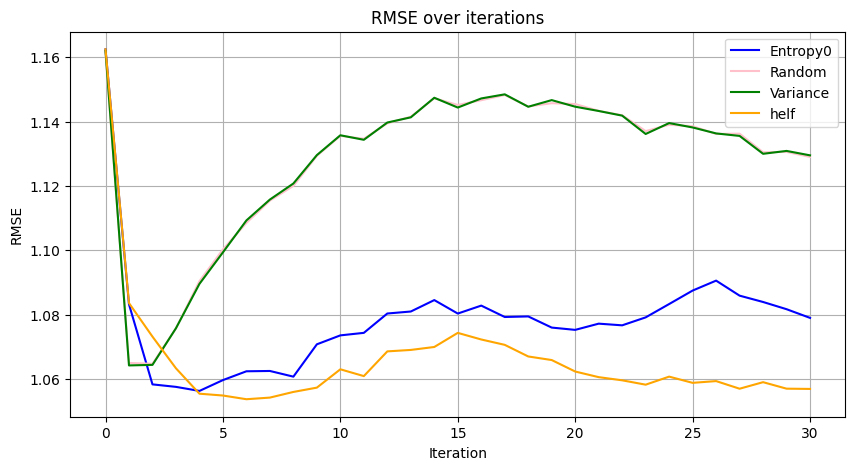

In [8]:
# plot rmse of both random and variance
plt.figure(figsize=(10, 5))
plt.plot(entropy0_rmse[0], label='Entropy0', color='blue')
plt.plot(random_rmse[0], label='Random', color='pink')
plt.plot(variance_rmse[0], label='Variance', color='green')
plt.plot(helf_rmse[0], label='helf', color='orange')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE over iterations')
plt.legend()
plt.grid()
plt.show()
